<h1 align="center"> Option Pricing Using Stochastic and Monte Carlo Methods</h1> 
<br></br>
<center>Jacob Fein-Ashley</center>

#### What is an option?
An option is a contract that allows the owner to buy or sell an underlying asset at a certain price. This strategy allows hedge funds and investment firms to gain massive leverage from smaller movements in asset prices, and will allow these funds to hedge other investments, or in other words, minimize loss. Pricing options is important to these firms to sell premiums to other buyers and correctly identify good premiums to buy.

### Black-Scholes Model
Perhaps the most widely known formulas in mathematical history, the Black-Scholes model won the Nobel Prize for economics in 1997. The model relates the price of a European option to the call option price (C), underlying price (S), strike price (K), risk free interest rate (r), time to maturity (t), a normal distribution (N), the dividend yield (q), and the volatility of a stock's return ($\sigma$). This strategy of option pricing has a few shortcomings that will be addressed later. The formula can be modeled by the following PDE


\begin{equation}
	\frac{\partial \mathrm C}{ \partial \mathrm t } + \frac{1}{2}\sigma^{2} \mathrm S^{2} \frac{\partial^{2} \mathrm C}{\partial \mathrm C^2}
	+ \mathrm r \mathrm S \frac{\partial \mathrm C}{\partial \mathrm S}\ =
	\mathrm r \mathrm C 
	\label{eq:1}
\end{equation}


Solving this PDE produces the following quantities where N(d1) is the "delta" of an option (how much an option (C) moves with the movement of the underlying asset), N(d2) is the probability an option will expire "in the money", and N(x) is the cumulative normal distribution function for expected values of d1 and d2:

\begin{equation}
	\mathrm C(\mathrm S,\mathrm t)= \mathrm N(\mathrm d_1)\mathrm S - \mathrm N(\mathrm d_2) \mathrm K \mathrm e^{-(r - q)t}
	\label{eq:2}
\end{equation}

\begin{equation}
	\mathrm d_1= \frac{1}{\sigma \sqrt{\mathrm t}} \left[\ln{\left(\frac{S}{K}\right)} + t\left(r - q + \frac{\sigma^2}{2} \right) \right]
\end{equation}

\begin{equation}
	\mathrm d_2= \frac{1}{\sigma \sqrt{\mathrm t}} \left[\ln{\left(\frac{S}{K}\right)} + t\left(r - q - \frac{\sigma^2}{2} \right) \right]
\end{equation}

\begin{equation}
	N(x)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} \mathrm e^{-\frac{1}{2}z^2} dz
	\label{eq:3}
\end{equation}

The Black-Scholes model can then be interpreted with this python program:

In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd

'''
Calculates a the cumulative and probability density functions and price
of a European option using the Black-Scholes model.
'''
#1st Parameter: Call/Put
#2nd Parameter: Underlying price
#3rd Parameter: Strike Price
#4th Parameter: Risk Free Interest Rate
#5th Parameter: Maturity Time (Years)
#6th Parameter: Historical Volatility Estimate
#7th Parameter (Optional): Dividend Yield (default = 0)
class BlackScholes:
    def __init__(self, option_type, price, strike, interest_rate, maturity, volatility, dividend_yield=0):
        self.s = price # Asset price
        self.k = strike # Strike Price
        self.r = interest_rate # Risk free interest
        self.q = dividend_yield # Dividend yield, defaulted to 0
        self.t = maturity # time to maturity
        self.sigma = volatility # Underlying volatility
        self.type = option_type # Option type, P for put, C for call
    '''
    N is a gaussian of the expected values for d1 and d2 as described.
    '''
    def N(self, d):
        return norm.cdf(d)
    '''
    D1 as described above.
    '''
    def d1(self):
        d1 = (np.log(self.s / self.k) + (self.r - self.q + self.sigma ** 2 * 0.5) * self.t) / (self.sigma * np.sqrt(self.t))
        return d1
    '''
    D2 as described above.
    Can be simplified to d1 - sigma * sqrt(maturity time)
    '''
    def d2(self):
        d2 = (np.log(self.s / self.k) + (self.r - self.q - self.sigma ** 2 * 0.5) * self.t) / (self.sigma * np.sqrt(self.t))
        return d2
    
    '''
    Calculates price of a European option using the Black-Scholes model as described above.
    '''
    def price(self):
        d1 = self.d1()
        d2 = d1 - self.sigma * np.sqrt(self.t)
        if self.type == 'c':
            price = np.exp(-self.r*self.t) * (self.s * np.exp((self.r - self.q)*self.t) * self.N(d1) - self.k * self.N(d2))
            return price
        elif self.type == 'p':
            price = np.exp(-self.r*self.t) * (self.k * self.N(-d2) - (self.s * np.exp((self.r - self.q)*self.t) * self.N(-d1)))
            return price
        else:
            print("Invalid input. Enter p for put option and c for call option.")
    

Now that the Black-Scholes model has been implemented, the model will be tested to a scraped dataset of an AAPL options chain. From a popular website, the current statistics of AAPL are as follows:
<br>
Historical volatility: 37.53%
</br>
<br>
Underlying Price: 122.64
</br>
<br>
Risk Free Interest Rate: 0.0164
</br>
<br>
Dividend Yield: 0.0065
</br>
And the scraped option chain appears below.

In [2]:
df = pd.read_csv("aaplOptionChain.csv")
df.head()

,Date,Last,Change,Bid,Ask,Volume,Open Int.,Strike
0,26-Mar,10.35,-3.40,10.20,10.35,13,301,112
1,26-Mar,9.60,-2.25,9.30,9.40,2,167,113
2,26-Mar,8.70,-2.10,8.40,8.50,48,242,114
3,26-Mar,7.70,-2.85,7.50,7.60,86,1089,115
4,26-Mar,6.90,-2.10,6.65,6.75,48,805,116


And the data will now be read to the Black Scholes model and compared to the actual options prices according to Nasdaq.

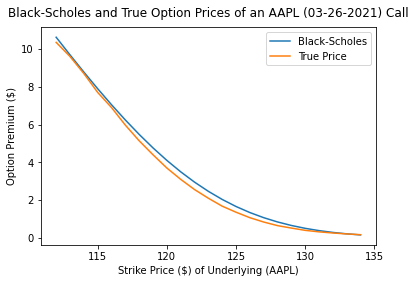

In [3]:
#making two lists, one for the black scholes price and one for the true price of the option
aaplBlackScholesList = []
aaplTruePriceList = []
aaplStrikeList = []
for ind in df.index:
    #getting estimated price using black scholes formula
    price = BlackScholes('c', 122.45, df['Strike'][ind] , 0.0164, 8/365, .3753, .0065).price()
    aaplBlackScholesList.append(price)
    aaplTruePriceList.append(df['Last'][ind])
    aaplStrikeList.append(df['Strike'][ind])
    
#importing matplotlib for data analysis
import matplotlib.pyplot as plt

plt.title("Black-Scholes and True Option Prices of an AAPL (03-26-2021) Call", y= 1.02)
plt.plot(aaplStrikeList, aaplBlackScholesList,label = 'Black-Scholes')
plt.plot(aaplStrikeList, aaplTruePriceList,label = 'True Price')
plt.xlabel("Strike Price ($) of Underlying (AAPL)")
plt.ylabel("Option Premium ($)")
plt.legend(loc="upper right")


In [4]:
bs_RMSE = np.sqrt(np.square(np.subtract(aaplTruePriceList,aaplBlackScholesList)).mean())
print("Black-Scholes RMSE: " , round(bs_RMSE, 4) )

Black-Scholes RMSE:  0.2553


#### Limitations of the Black-Scholes Model
Although the Black-Scholes model seemed to perform well on a stationary dataset, the model has many flaws that make it unrealistic to use. The glaring issue with this model is that it has been developed to fit European options, that is, this model does not account that the buyer can exercise (as discussed earlier, exercising means giving the buyer the right to buy or sell the number of specified shares at the strike price) the option early. The model also assumes constant option volatility throughout the duration of the option's lifetime, which is wildly unrealistic given the volatility of an asset will fluctuate violently in some cases. There are many other flaws with this model that make it unrealistic to use in modern day option pricing. 

### Modern Day Option Pricing
Modern day options employ a vast array of mathematical and computational techniques to more accurately account for these errors we have discussed previously. These methods will be discussed and evaluated in the next sections.